# Exercise 2:  Working with motifs and distributions in Python

In this notebook we will go over some concepts that will help you with programming the Gibbs sampling algorithm.

### Counting stuff in Python

Python's [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) variant of the standard dictionary is useful for counting stuff, e.g. occurrences of nucleotides in a sequence:

In [1]:
import collections
sequence = "CATGATCTCATCGTACGCAACG"
counts = collections.defaultdict(int)
for char in sequence :
    counts[char]+=1
    
counts

defaultdict(int, {'C': 7, 'A': 6, 'T': 5, 'G': 4})

Without defaultdict we would have needed to first check if a key is in the dictionary:

In [2]:
sequence = "CATGATCTCATCGTACGCAACG"
counts = {}
for char in sequence :
    if char not in counts :
        counts[char]=0
    counts[char]+=1
counts

{'C': 7, 'A': 6, 'T': 5, 'G': 4}

In [3]:
sequence = "CATGATCTCATCGTACGCAACG"
counts = {'A':0, 'C':0,'G':0,'T':0}
for char in sequence :
    counts[char]+=1
counts

{'A': 6, 'C': 7, 'G': 4, 'T': 5}

The final way we can program this uses Python's [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class:

In [4]:
collections.Counter("CATGATCTCATCGTACGCAACG")

Counter({'C': 7, 'A': 6, 'T': 5, 'G': 4})

### Sampling from a probability distribution

When implementing randomized algorithms we often need to make random choices according to a probability distribution, i.e. we need to *sample* from that distribution.

The simplest distribution to sample from is the **multinomial distribution**, which is specified by a vector of parameters
$p_1, \ldots, p_n$ where $\sum_{i=1}^n p_i = 1$.

To sample from a multinomial distribution, bin the numbers between 0 and 1 into $n$ bins, each with a size $p_i$.  Then pick a random number between 0 and 1 and decide the outcome according to which bin it falls into.

To implement this, you can use

In [5]:
import numpy as np
rng = np.random.default_rng(42)
rng.random()

0.7739560485559633

which generates a pseudo-random number between 0 and 1.

As an alternative, we can use numpy's [choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) method of a random number generator:

In [6]:
distribution = [0.1, 0.2, 0.5,0.2]
rng.choice(['A','C','G','T'], p=distribution)

np.str_('G')

or use numpy's [multinomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html) method:

In [7]:
distribution = [0.1, 0.2, 0.5,0.2]
rng.multinomial(1, distribution)

array([0, 0, 1, 0])

### Working with motifs

In our last exercise, we will look at the sequences of introns in the model plant arabidopsis.
The first few nucleotides and the last few nucleotides in each sequence have signals in them that help delineate the boundaries of the introns.
First we will read the sequences of those introns, and then analyze the nucleotide composition at each end of the sequence.

In [8]:
"""
A parser for FASTA files.

It can handle files that are local or on the web.
Gzipped files do not need to be unzipped.
"""

import os
from urllib.request import urlopen

def myopen(fileName) :

    if not ( os.path.exists(fileName) and os.path.isfile(fileName) ):
        raise ValueError('file does not exist at %s' % fileName)
    
    import gzip
    fileHandle = gzip.GzipFile(fileName)

    gzippedFile = True
    try :
        line = fileHandle.readline()
        fileHandle.close()
    except :
        gzippedFile = False

    if gzippedFile :
        return gzip.GzipFile(fileName)
    else :
        return open(fileName)


class MalformedInput :
    "Exception raised when the input file does not look like a fasta file."
    pass

class FastaRecord :
    """Represents a record in a fasta file."""
    def __init__(self, header, sequence):
        """Create a record with the given header and sequence."""
        self.header = header
        self.sequence = sequence
    def __str__(self) :
        return '>' + self.header + '\n' + self.sequence + '\n'

    
def _fasta_itr_from_file(file_handle) :
    "Provide an iteration through the fasta records in file."

    h = file_handle.readline()[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))

        
def _fasta_itr_from_web(file_handle) :
    "Iterate through a fasta file posted on the web."

    h = file_handle.readline().decode("utf-8")[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line.decode("utf-8")[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))



def _fasta_itr_from_name(fname):
    "Iterate through a fasta file with the given name."

    f = myopen(fname)
    for rec in _fasta_itr_from_file(f) :
        yield rec


def _fasta_itr(src):
    """Provide an iteration through the fasta records in file `src'.
    
    Here `src' can be either a file name or a url of a file.
    """
    if type(src) == str :
        if src.find("http")>=0 :
            file_handle = urlopen(src)
            return _fasta_itr_from_web(file_handle)
        else :
            return _fasta_itr_from_name(src)
    else:
        raise TypeError

    
class fasta_itr (object) :
    """An iterator through a Fasta file"""

    def __init__(self, src) :
        """Create an iterator through the records in src."""
        self.__itr = _fasta_itr(src)

    def __iter__(self) :
        return self

    def __next__(self) :
        return self.__itr.__next__()



Using this fasta parser, let's read the sequences, which are posted on github:

In [9]:
fasta_iterator = fasta_itr("https://raw.githubusercontent.com/asabenhur/CS425/main/data/arabidopsis_introns.fasta")
sequences = [fasta_record.sequence 
             for fasta_record in fasta_iterator]

In [10]:
len(sequences)

54664

In [11]:
motif_length = 10
donor_sequences = [sequence[:motif_length] 
                      for sequence in sequences]

In [12]:
donor_sequences[0]

'GTTAGCTTCC'

With this data, we will first look at the motif at the 5' end of the sequence, which is called the *donor* motif.  In your analysis look at the first 10 nucleotides of each intron.

* Plot the information content in each position of the motif and compute its total information content.  Similarly, plot the relative entropy per position and compute its overall value.  Comment on the results!  Based on your results, how far into the intron does the motif extend?

Recall that information content of a position in the motif is defined as:

$$
\log_2 4 - \left( - \sum_{i=1}^4 f_i \log_2 f_i \right)
$$
where $f_i$ is the observed frequency of nucleotide $i$.  
Relative entropy is defined as:

$$
 \left( \sum_{i=1}^4 f_i \log_2 \frac{f_i}{p_i} \right)
$$
where $p_i$ is the background frequency of nucleotide $i$.


* Perform a similar analysis of the acceptor motif, which is on the 3' end of the sequence.  Which part of the sequence has a stronger motif?


In [13]:
# the goal is to build a motif logo
# to do this we must:
# grab the first 10 and last 10 characters of each sequence
# calculate profile
    # calculate count matrix (nucliotides x position)
    # add 1 (remove 0s) pseudocount Matrix
    # Calculate probablility matrix (divide by vector of sum of columns)
# calculate information
    # f is from count matrix
    # p is from probablity matrix
# calculate entropy
    # same as information

In [14]:
threePrime = [s[-motif_length:] for s in sequences]
fivePrime = donor_sequences

In [15]:
print(num_seq:=len(threePrime), len(fivePrime)) # I should use assert statments more frequently to check my data

54664 54664


In [16]:
import numpy as np
def get_counts_matrix(seq:list) -> np.array: # num_nuc x n
    nuc_index = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
    counts = np.zeros([len(nuc_index), len(seq[0])])
    for i_s, s in enumerate(seq):
        for i_n, n in enumerate(s):
            counts[nuc_index[n], i_n] += 1
    return counts


threeCounts = get_counts_matrix(threePrime)
fiveCounts = get_counts_matrix(fivePrime)

In [17]:
def get_profile_matrix(counts):
    counts += 1 # pseudo counts
    sums = np.sum(counts, axis=0)
    profile = counts/sums
    return profile


threeProfile = get_profile_matrix(threeCounts)
fiveProfile = get_profile_matrix(fiveCounts)

In [18]:
def calculate_information_matrix(profile):
    I = np.zeros([motif_length])
    for p in range(profile.shape[1]):
        I[p] = np.log2(4) - (np.sum(profile[:, p] * np.log2(profile[:, p])))
    return I


threeInformation = calculate_information_matrix(threeProfile)
fiveInformation = calculate_information_matrix(fiveProfile)

In [19]:
def calculate_entropy_matrix(profile):
    p = 0.25 # assumption: all base pairs appear at the same frequency
    RE = np.zeros(motif_length)
    for i in range(motif_length):
        RE[i] = np.sum(profile[:, i] * np.log2(profile[:, i]/p))
    return RE


threeRE = calculate_entropy_matrix(threeProfile)
fiveRE = calculate_entropy_matrix(fiveProfile)


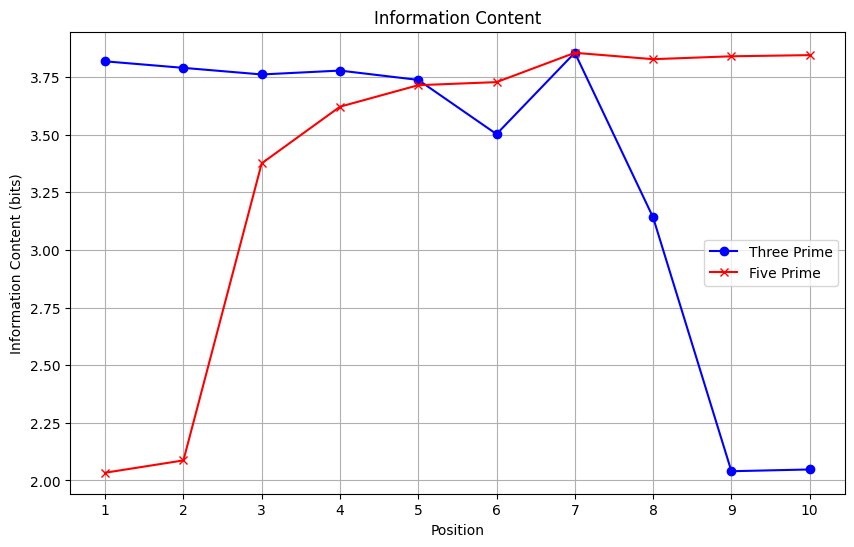

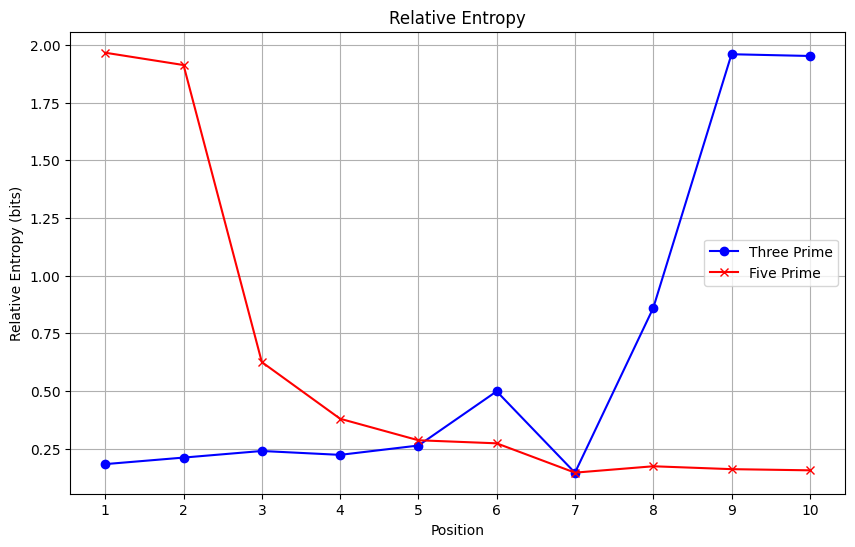

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), threeInformation, marker='o', color='b', label='Three Prime')
plt.plot(range(1, 11), fiveInformation, marker='x', color='r', label='Five Prime')
plt.xlabel('Position')
plt.ylabel('Information Content (bits)')
plt.title('Information Content')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), threeRE, marker='o', color='b', label='Three Prime')
plt.plot(range(1, 11), fiveRE, marker='x', color='r', label='Five Prime')
plt.xlabel('Position')
plt.ylabel('Relative Entropy (bits)')
plt.title('Relative Entropy')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()

There seems to information associated with the splicing of RNA introns, with similar amounts in both the 3' and 5' slicing sections. This makes sense because RNA splicing is preformed by a proteins that probably grab both before and after the splice and then preform a splice.  

This can be seen by the information in the 3' and 5' splices, because there is more information near the splicing point. There is also less entorpy in those regions indicating more order.